In [8]:
from google.colab import drive
import os

import torch
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import pandas as pd
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay


In [9]:

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [10]:
import sys
sys.path.append('/content/gdrive/My Drive/')
import model_architectures as ma

In [11]:
manualSeed = 500

torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)

In [ ]:
fixed_noise = torch.randn(1000,  ma.nz, 1, 1)
fake1_test = netG1(fixed_noise).detach().numpy().reshape(1000,28,28)
fake2_test = netG2(fixed_noise).detach().numpy().reshape(1000,28,28)
fake3_test = netG3(fixed_noise).detach().numpy().reshape(1000,28,28)

In [ ]:
np.save('/content/gdrive/My Drive/Diss/Images_Testing/GAN_1_images', fake1_test)
np.save('/content/gdrive/My Drive/Diss/Images_Testing/GAN_2_images', fake2_test)
np.save('/content/gdrive/My Drive/Diss/Images_Testing/GAN_3_images', fake3_test)
np.save('/content/gdrive/My Drive/Diss/Images_Testing/Real_images', real_test)

In [12]:
def load_fingerprints(fp_extraction_method, denoising_method="median blur"):
  dir = '/content/gdrive/My Drive/Diss/{}/Fingerprints/'.format(fp_extraction_method)
  file_names = ['print_real', 'print_GAN_1', 'print_GAN_2', 'print_GAN_3']
  if(fp_extraction_method == 'Marra'):
    file_names = [f + '_' + denoising_method.replace(" ", "_") for f in file_names]
  fingerprints = [np.load(dir + f + '.npy').flatten() for f in file_names ]
  return fingerprints
  

In [13]:
def compute_corr_coeff(gan_num, fp_extraction_method, denoising_method="median blur"):
  coefs_list = [[],[],[],[]]
  file_name_load = "GAN_{:d}_images.npy".format(gan_num) if gan_num > 0 else "Real_images.npy"
  fake_test = np.load('/content/gdrive/My Drive/Diss/Images_Testing/'+file_name_load)
  fp_list = load_fingerprints(fp_extraction_method, denoising_method)
  if(fp_extraction_method == 'Yu'):
    autoEnc = ma.Autoencoder()
    model_dict = torch.load('/content/gdrive/My Drive/Diss/trained_models/Autoencoder', map_location=torch.device('cpu'))
    autoEnc.load_state_dict(model_dict['model_state_dict'])
  for i in range(1000):
    img = fake_test[i]
    if (fp_extraction_method == 'Marra'):
      if (denoising_method == "median blur"):
        dst = cv2.medianBlur(img, 3)
      elif (denoising_method == "gaussian blur"):
        dst = cv2.GaussianBlur(img, (3,3), 1)
    elif (fp_extraction_method == 'Yu'):
      dst = autoEnc(torch.from_numpy(img.reshape(1,1,28,28)))
      dst = dst.detach().numpy().reshape(28,28)
      
    residual = (img - dst).flatten()
    for i in range(len(coefs_list)):
      coefs_list[i].append(np.corrcoef(fp_list[i], residual)[0][1]) 
  return coefs_list


In [14]:
def plot_corr_histograms(fp_extraction_method): 
  fig, ax = plt.subplots(1,4,figsize=(15,4), sharex=True, sharey=True)
  for i in range(4):
    coefs_real, coefs_gan_1, coefs_gan_2, coefs_gan_3 = compute_corr_coeff(i, fp_extraction_method)
    ax[i].hist(coefs_real, color='red', alpha= 0.25, label="real")
    ax[i].hist(coefs_gan_1, color='blue', alpha = 0.2, label="GAN 1")
    ax[i].hist(coefs_gan_2, color='yellow', alpha = 0.2, label="GAN 2")
    ax[i].hist(coefs_gan_3, color='green', alpha = 0.2, label="GAN 3")
    ax[i].set_xlabel('Correlation')
  plt.legend()
  plt.show()

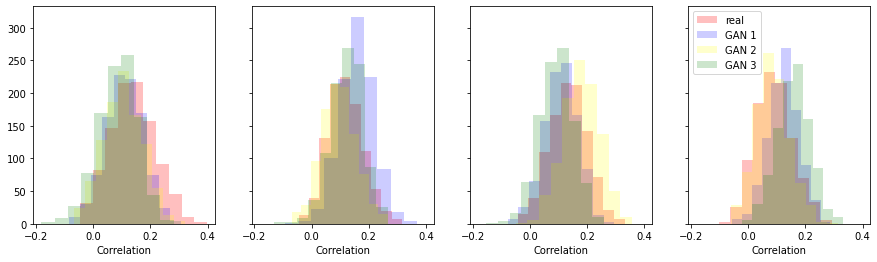

In [45]:
plot_corr_histograms('Marra')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


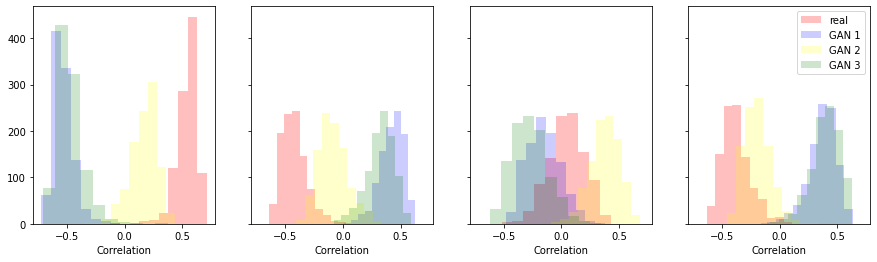

In [69]:
plot_corr_histograms('Yu')

In [15]:
def get_predictions(fp_extraction_method, denoising_method="median blur"):
  labels = ['real', 'GAN 1', 'GAN 2', 'GAN 3']
  preds = []
  fp_list = load_fingerprints(fp_extraction_method, denoising_method)
  if(fp_extraction_method == 'Yu'):
    autoEnc = ma.Autoencoder()
    model_dict = torch.load('/content/gdrive/My Drive/Diss/trained_models/Autoencoder', map_location=torch.device('cpu'))
    autoEnc.load_state_dict(model_dict['model_state_dict'])
  for gan_num in range(4):
    file_name_load = "GAN_{:d}_images.npy".format(gan_num) if gan_num > 0 else "Real_images.npy"
    fake_test = np.load('/content/gdrive/My Drive/Diss/Images_Testing/'+file_name_load)
    for i in range(1000):
      img = fake_test[i]
      if (fp_extraction_method == 'Marra'):
        if (denoising_method == "median blur"):
          dst = cv2.medianBlur(img, 3)
        elif (denoising_method == "gaussian blur"):
          dst = cv2.GaussianBlur(img, (3,3), 1)
        residual = (img - dst).flatten()
        dist_list = [np.linalg.norm(fp - residual) for fp in fp_list]
        preds.append(labels[dist_list.index(min(dist_list))])
      elif (fp_extraction_method == 'Yu'):
        dst = autoEnc(torch.from_numpy(img.reshape(1,1,28,28)))
        dst = dst.detach().numpy().reshape(28,28)
        residual = (img - dst).flatten()
        coef_list = [np.corrcoef(fp, residual)[0][1] for fp in fp_list]
        preds.append(labels[coef_list.index(max(coef_list))])
  return preds

In [38]:
labels = ['real', 'GAN 1', 'GAN 2', 'GAN 3']

In [40]:
def plot_confusion_matrix(preds):
  cm = confusion_matrix(ground_truth, preds, labels)
  cm_plot = ConfusionMatrixDisplay(cm, labels)
  cm_plot.plot( include_values=True, values_format='d')
  plt.show()

In [60]:
from sklearn.metrics import precision_recall_fscore_support
def plot_prec_recall_chart(preds):
  scores = precision_recall_fscore_support(ground_truth, preds, labels = labels)
  precision_scores = scores[0]
  recall_scores = scores[1]

  ind = np.arange(4)  # the x locations for the groups
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(ind - width/2, precision_scores, width, label='Precision')
  rects2 = ax.bar(ind + width/2, recall_scores, width, label='Recall')

  ax.set_xticks(ind)
  ax.set_xticklabels(labels)

  ax.set_ylim(0,1.2)
  ax.legend()

  for rect in rects1+rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(round(height, 3)),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')


  plt.axhline(y=0.25,linestyle='dashed', color='k')
  plt.yticks([0.00, 0.20, 0.25, 0.40, 0.60, 0.80, 1.00,1.20], [0.00, 0.20, 'Baseline' ,0.40,0.60,0.80,1.00])

  fig.tight_layout()

  plt.show()


In [16]:
ground_truth = (['real']*1000) + (['GAN 1']*1000) + (['GAN 2']*1000) + (['GAN 3']*1000)

In [21]:
marra_preds = get_predictions('Marra')
np.save('/content/gdrive/My Drive/Diss/Marra/Predictions/NN_median_blur', marra_preds)

In [49]:
print("Accuracy of Marra method = {}".format(accuracy_score(ground_truth, marra_preds)))

Accuracy of Marra method = 0.63025


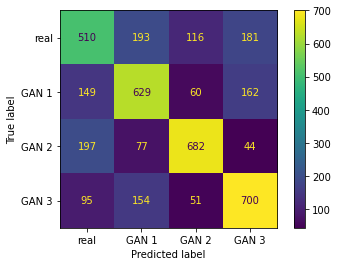

In [61]:
plot_confusion_matrix(marra_preds)



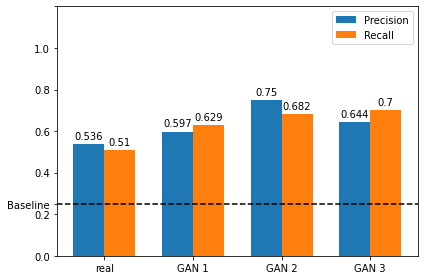

In [62]:
plot_prec_recall_chart(marra_preds)

In [26]:
yu_preds = get_predictions('Yu')




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [51]:
print("Accuracy of Yu method = {}".format(accuracy_score(ground_truth, yu_preds)))

Accuracy of Yu method = 0.8785


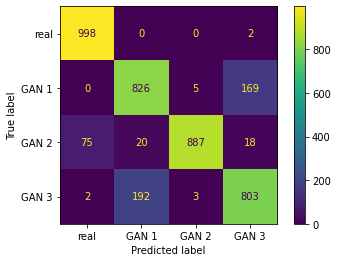

In [45]:
plot_confusion_matrix(yu_preds)

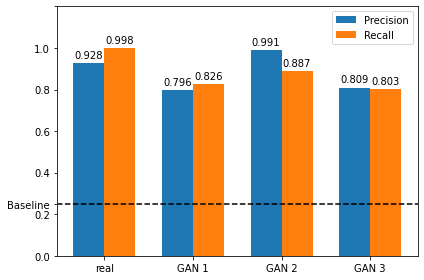

In [63]:
plot_prec_recall_chart(yu_preds)